## 통계적 가설검정부터 비지도학습까지

1. 위험고객의 특징 탐색(insight)
2. 중신용고객의 특징 탐색 후 금융상품 기획(unsupervised-learning)

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from collections import Counter
import missingno as msno
from typing import *
  # [데이터프레임 핸들링, 선형대수, 통계적 가설검정, 결측값 처리 목적 라이브러리 모듈]

from google.colab import drive
drive.mount("/content/drive")
  # [코랩에 구글 드라이브 마운트]

from sklearn.preprocessing import *
  # [연속형 변수 스케일링 및 범주형 변수 인코딩 목적 모든 라이브러리 모듈]
from sklearn.model_selection import train_test_split
  # [훈련용 및 검증용 데이터 셋 분할 목적 라이브러리 모듈]
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
  # [K-폴드 교차검증(랜덤 또는 타겟하는 클래스 변수 비율 층화) 및 그리드 서치 목적 라이브러리 모듈]

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import export_graphviz
  # [데이터 시각화 모듈]

from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from lightgbm import plot_importance

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from mlxtend.plotting import plot_decision_regions
  # [분류 모델 모듈]

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, classification_report
  # [성능 평가 지표 모듈]

from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
  # [클래스 불균형 모듈]

from sklearn.decomposition import PCA
  # [클래스 불균형 확인 시각화 모듈]

from sklearn.metrics import fbeta_score, make_scorer
  # [f-beta score 모듈]

import scipy.stats as stats
from scipy.stats import normaltest
from scipy.stats import shapiro
from scipy.stats import anderson
from scipy.stats import kstest
  # [정규성 검정을 위한 모듈]

from scipy.stats import bartlett
from scipy.stats import levene
  # [등분산성 검정을 위한 모듈]

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

Mounted at /content/drive


In [ ]:
# 빠른 재현성을 위한 csv 파일을 구글드라이브에 저장 후 로드
# NewImpact > 데이터 > classification_credit_client 파일에 저장

creditRisk_client = pd.read_csv("/content/drive/MyDrive/creditRisk_client.csv", index_col = False)
stableCredit_client = pd.read_csv("/content/drive/MyDrive/stableCredit_client.csv", index_col = False)

In [ ]:
print(creditRisk_client.shape, stableCredit_client.shape)

(131461, 128) (119514, 128)


#### LightGBM에서 상위 30개의 특징 중요도가 높은(지니 지수 기반의 트리의 노드 불순도에 대한 기여가 높은, "split") 특성변수

* "AMT_GOODS_PRICE_x", "AMT_CREDIT_x",  "AMT_ANNUITY_x", "DAYS_EMPLOYED", "AMT_APPLICATION", "AMT_ANNUITY_y", AMT_CREDIT_y"
* "duplicate", "GENERATION_30.0"
* "NAME_EDUCATION_TYPE_Higher_education", "NAME_EDUCATION_TYPE_Secondary_special",
* "ORGANIZATION_TYPE_entity_type", "ORGANIZATION_TYPE_Medicine", "ORGANIZATION_TYPE_trade type", "ORGANIZATION_TYPE_industry type","OCCUPATION_TYPE_Laborers", "ORGANIZAITON_TYPE_Self employed", "OCCUPATION_TYPE_High-skill tech staff", "OCCUPATION_TYPE_Sales staff", "OCCUPATION_TYPE_Core-staff"
* "NAME_INCOME_TYPE_Commercial_associate", "NAME_INCOME_TYPE_Working", "NAME_HOUSING_TYPE_House / apartment", "NAME_CONTRACT_TYPE_x_Cash loans",
* "NAME_GOODS_CATEGORY_Mobile", "NAME_GOODS_CATEGORY_Computers", "NAME_GOODS_CATEGORY_Construction Materials", "NAME_GOODS_CATEGORY_Audio/Video","NAME_GOODS_CATEGORY_Clothing_and_Accessories", "NAME_GOODS_CATEGORY_Consumer Electronics"

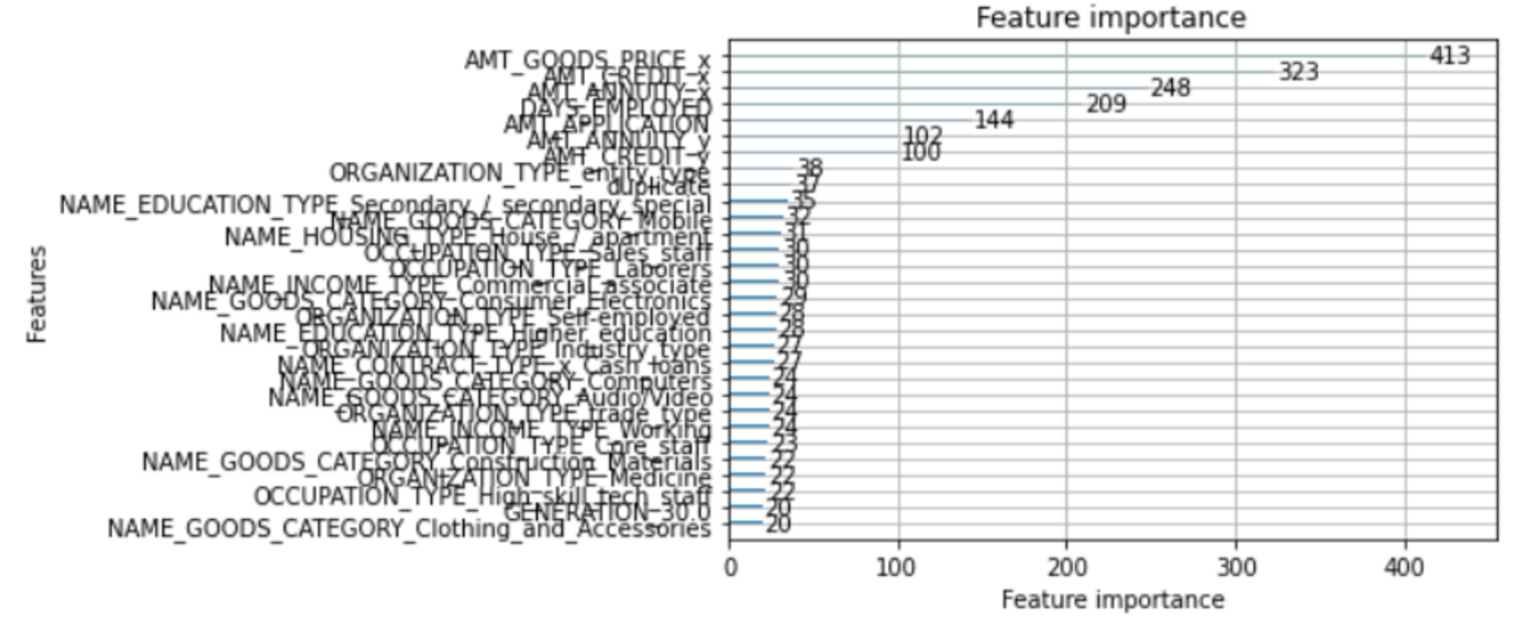

In [ ]:
# LightGBM 모델의 트리 분할에 기여도가 높은(지니 지수 기반의 불순도를 낮추는) 상위 특성변수

featureImportantColumns: List = [
    "AMT_GOODS_PRICE_x", "AMT_CREDIT_x",  "AMT_ANNUITY_x", "DAYS_EMPLOYED", "AMT_APPLICATION", "AMT_ANNUITY_y", "AMT_CREDIT_y",
    "duplicate", "GENERATION_20.0", "GENERATION_30.0", "GENERATION_40.0", "GENERATION_50.0", "GENERATION_60.0",
    "NAME_EDUCATION_TYPE_Higher education", "NAME_EDUCATION_TYPE_Secondary / secondary special",
    "ORGANIZATION_TYPE_entity_type", "ORGANIZATION_TYPE_Medicine", "ORGANIZATION_TYPE_trade_type", "ORGANIZATION_TYPE_Industry_type","OCCUPATION_TYPE_Laborers", "ORGANIZATION_TYPE_Self-employed", "OCCUPATION_TYPE_High skill tech staff", "OCCUPATION_TYPE_Sales staff", "OCCUPATION_TYPE_Core staff",
    "NAME_INCOME_TYPE_Commercial associate", "NAME_INCOME_TYPE_Working", "NAME_HOUSING_TYPE_House / apartment", "NAME_CONTRACT_TYPE_x_Cash loans", "CODE_REJECT_REASON_CLIENT",
    "NAME_GOODS_CATEGORY_Mobile", "NAME_GOODS_CATEGORY_Computers", "NAME_GOODS_CATEGORY_Construction Materials", "NAME_GOODS_CATEGORY_Audio/Video", "NAME_GOODS_CATEGORY_Clothing and Accessories", "NAME_GOODS_CATEGORY_Consumer Electronics"
]
creditRisk_client = creditRisk_client.loc[:, featureImportantColumns]
  # [CODE_REJECT_REASON_{}, GENERATION_60.0] 모델의 상위 30개 중요도 높은 특성변수에서 제외되었으나 신용리스크 평가 도메인에 따라 포함

In [ ]:
# 더미변수 타입 변환 (int64 -> category)

creditRisk_client.iloc[:, 7:35] = creditRisk_client.iloc[:, 7:35].astype("category")

'''
# Trial & Error 1
for i in range(len(Capital_creditRisk_client.columns)) :
  if type(Capital_creditRisk_client.iloc[:, i]) == "int64":
    Capital_creditRisk_client.iloc[:, i] = Capital_creditRisk_client.iloc[:, i].astype("category")

# [Trial & Error 2]
Capital_creditRisk_client.select_dtypes(include = "int").columns = Capital_creditRisk_client.select_dtypes(include = "int").columns.astype("category")
'''

'\n# Trial & Error 1\nfor i in range(len(Capital_creditRisk_client.columns)) :\n  if type(Capital_creditRisk_client.iloc[:, i]) == "int64":\n    Capital_creditRisk_client.iloc[:, i] = Capital_creditRisk_client.iloc[:, i].astype("category")\n\n# [Trial & Error 2]\nCapital_creditRisk_client.select_dtypes(include = "int").columns = Capital_creditRisk_client.select_dtypes(include = "int").columns.astype("category")\n'

In [ ]:
# 함수로 만들기

def transform(X: pd.DataFrame):
  # 세대(연령대) 더미변수 20, 30, 40, 50, 60대를 하나의 범주형 변수로 통합
  X["GENERATION"] = 0
  X.columns.get_loc("GENERATION")
  for i in [20.0, 30.0, 40.0, 50.0, 60.0]:
    print(Counter(X["GENERATION_{}".format(i)]))
  for i in [20.0, 30.0, 40.0, 50.0, 60.0]:
    X.loc[X[X["GENERATION_{}".format(i)] == 1].index.tolist(), "GENERATION"] = i
  for i in [20.0, 30.0, 40.0, 50.0, 60.0]:
    X.drop(["GENERATION_{}".format(i)], axis = 1, inplace = True)

  X["GENERATION"] = X["GENERATION"].astype("category")

  # 교육수준 더미변수를 하나의 범주형 변수로 통합
  for i in ["Higher education", "Secondary / secondary special"]:
    print(Counter(X["NAME_EDUCATION_TYPE_{}".format(i)]))
  # 교육수준 high/secondary 둘 중 어떤 범주에도 포함되지 않는 고객 3,110명의 데이터를 결측값 처리
  print(
      len(X[(X["NAME_EDUCATION_TYPE_Higher education"] == 1) & (X["NAME_EDUCATION_TYPE_Secondary / secondary special"] == 0)]),
      len(X[(X["NAME_EDUCATION_TYPE_Higher education"] == 0) & (X["NAME_EDUCATION_TYPE_Secondary / secondary special"] == 1)]),
      len(X[(X["NAME_EDUCATION_TYPE_Higher education"] == 0) & (X["NAME_EDUCATION_TYPE_Secondary / secondary special"] == 0)]),
      len(X[(X["NAME_EDUCATION_TYPE_Higher education"] == 1) & (X["NAME_EDUCATION_TYPE_Secondary / secondary special"] == 1)]))

  X["EDUCATION_TYPE"] = 0

  for i in ["Higher education", "Secondary / secondary special"]:
    X.loc[X[X["NAME_EDUCATION_TYPE_{}".format(i)] == 1].index.tolist(), "EDUCATION_TYPE"] = i
  for i in ["Higher education", "Secondary / secondary special"]:
    X.drop(["NAME_EDUCATION_TYPE_{}".format(i)], axis = 1, inplace = True)
  X["EDUCATION_TYPE"] = X["EDUCATION_TYPE"].astype("category")
  Counter(X["EDUCATION_TYPE"])

  # 직업, 소득유형변수 중 소득유형 더미변수를 하나의 범주형 변수로 통합
  for i in ["entity_type", "Medicine", "trade_type", "Industry_type", "Self-employed"]:
    print(Counter(X["ORGANIZATION_TYPE_{}".format(i)]))

  X["ORGANIZATION_TYPE"] = 0

  for i in ["entity_type", "Medicine", "trade_type", "Industry_type", "Self-employed"]:
    X.loc[X[X["ORGANIZATION_TYPE_{}".format(i)] == 1].index.tolist(), "ORGANIZATION_TYPE"] = i
  for i in ["entity_type", "Medicine", "trade_type", "Industry_type", "Self-employed"]:
    X.drop(["ORGANIZATION_TYPE_{}".format(i)], axis = 1, inplace = True)

  X["ORGANIZATION_TYPE"] = X["ORGANIZATION_TYPE"].astype("category")


  # 과거 신용대출받은 대금으로 결제한 소비재의 더미변수 : What kind of goods did the client apply for in the previous application
  for i in ["Mobile", "Computers", "Construction Materials", "Audio/Video", "Consumer Electronics", "Clothing and Accessories"]:
    print(Counter(X["NAME_GOODS_CATEGORY_{}".format(i)]))

  X["NAME_GOODS_CATEGORY"] = 0

  for i in ["Mobile", "Computers", "Construction Materials", "Audio/Video", "Consumer Electronics", "Clothing and Accessories"]:
    X.loc[X[X["NAME_GOODS_CATEGORY_{}".format(i)] == 1].index.tolist(), "NAME_GOODS_CATEGORY"] = i
  for i in ["Mobile", "Computers", "Construction Materials", "Audio/Video", "Consumer Electronics", "Clothing and Accessories"]:
    X.drop(["NAME_GOODS_CATEGORY_{}".format(i)], axis = 1, inplace = True)

  X["NAME_GOODS_CATEGORY"] = X["NAME_GOODS_CATEGORY"].astype("category")


  # OCCUPATION_TYPE
  for i in ["Laborers", "High skill tech staff", "Sales staff", "Core staff"]:
    print(Counter(X["OCCUPATION_TYPE_{}".format(i)]))

  X["OCCUPATION_TYPE"] = 0

  for i in ["Laborers", "High skill tech staff", "Sales staff", "Core staff"]:
    X.loc[X[X["OCCUPATION_TYPE_{}".format(i)] == 1].index.tolist(), "OCCUPATION_TYPE"] = i
  for i in ["Laborers", "High skill tech staff", "Sales staff", "Core staff"]:
    X.drop(["OCCUPATION_TYPE_{}".format(i)], axis = 1, inplace = True)

  X["OCCUPATION_TYPE"] = X["OCCUPATION_TYPE"].astype("category")


  # NAME_INCOME_TYPE
  for i in ["Commercial associate", "Working"]:
    print(Counter(X["NAME_INCOME_TYPE_{}".format(i)]))

  X["INCOME_TYPE"] = 0

  for i in ["Commercial associate", "Working"]:
    X.loc[X[X["NAME_INCOME_TYPE_{}".format(i)] == 1].index.tolist(), "INCOME_TYPE"] = i
  for i in ["Commercial associate", "Working"]:
    X.drop(["NAME_INCOME_TYPE_{}".format(i)], axis = 1, inplace = True)

  X["INCOME_TYPE"] = X["INCOME_TYPE"].astype("category")
  print(Counter(X["INCOME_TYPE"]))

In [ ]:
'''
ORGANIZATION_TYPE_
OCCUPATION_TYPE
NAME_GOODS_CATEGORY
'''
transform(creditRisk_client)

Counter({0: 108624, 1: 22837})
Counter({0: 79640, 1: 51821})
Counter({0: 97475, 1: 33986})
Counter({0: 116049, 1: 15412})
Counter({0: 124056, 1: 7405})
Counter({0: 117375, 1: 14086})
Counter({1: 113868, 0: 17593})
14086 113868 3507 0
Counter({0: 85778, 1: 45683})
Counter({0: 128953, 1: 2508})
Counter({0: 126875, 1: 4586})
Counter({0: 128144, 1: 3317})
Counter({0: 112760, 1: 18701})
Counter({0: 100467, 1: 30994})
Counter({0: 115510, 1: 15951})
Counter({0: 130351, 1: 1110})
Counter({0: 117925, 1: 13536})
Counter({0: 115842, 1: 15619})
Counter({0: 130659, 1: 802})
Counter({0: 86120, 1: 45341})
Counter({0: 130538, 1: 923})
Counter({0: 113018, 1: 18443})
Counter({0: 124122, 1: 7339})
Counter({0: 108855, 1: 22606})
Counter({1: 89348, 0: 42113})
Counter({'Working': 89348, 'Commercial associate': 22606, 0: 19507})


In [ ]:
creditRisk_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131461 entries, 0 to 131460
Data columns (total 17 columns):
 #   Column                               Non-Null Count   Dtype   
---  ------                               --------------   -----   
 0   AMT_GOODS_PRICE_x                    131461 non-null  int64   
 1   AMT_CREDIT_x                         131461 non-null  int64   
 2   AMT_ANNUITY_x                        131461 non-null  int64   
 3   DAYS_EMPLOYED                        131461 non-null  int64   
 4   AMT_APPLICATION                      131461 non-null  int64   
 5   AMT_ANNUITY_y                        131461 non-null  int64   
 6   AMT_CREDIT_y                         131461 non-null  int64   
 7   duplicate                            131461 non-null  category
 8   NAME_HOUSING_TYPE_House / apartment  131461 non-null  category
 9   NAME_CONTRACT_TYPE_x_Cash loans      131461 non-null  category
 10  CODE_REJECT_REASON_CLIENT            131461 non-null  category
 11  

#### 신용위험(대출채권 연체 또는 손상) 고객의 특징 탐색적 데이터 분석 및 통계적 가설검정

##### 1) 정규성 검정

In [ ]:
# 연속형 변수만 추출한 데이터 프레임 생성

risk_client_num = creditRisk_client.select_dtypes(include = ["int64"])
risk_client_num

,AMT_GOODS_PRICE_x,AMT_CREDIT_x,AMT_ANNUITY_x,DAYS_EMPLOYED,AMT_APPLICATION,AMT_ANNUITY_y,AMT_CREDIT_y
0,450000,532361,26987,2383,123594,13173,128545
1,264051,312473,17742,1590,25520,5319,26236
2,314468,314468,30158,1426,29349,3407,30063
3,185071,185071,7942,1029,64935,11306,65903
4,685989,835397,41691,1736,60869,9707,71514
...,...,...,...,...,...,...,...
131456,463500,562218,29356,810,67988,10881,73655
131457,917260,1067587,31345,1414,556529,32107,588044
131458,450000,544604,25571,984,65093,8321,71147
131459,945000,1052388,35740,4545,88483,12056,95823


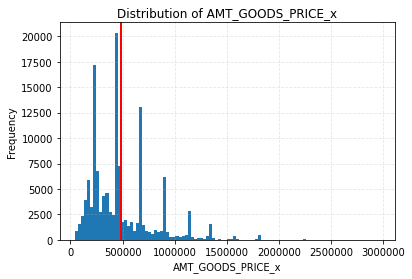

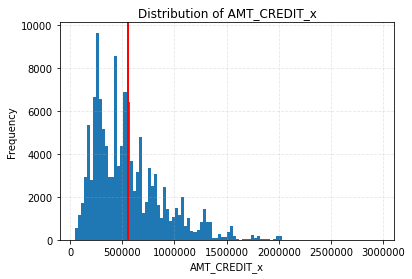

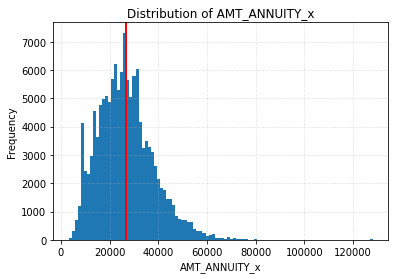

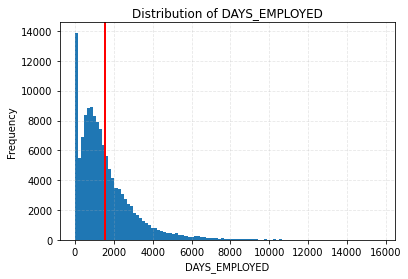

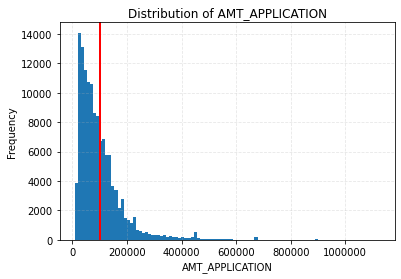

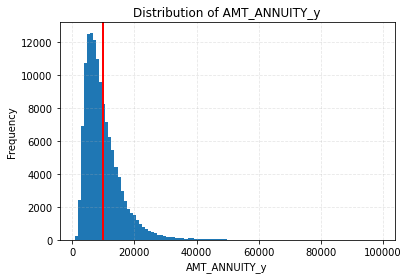

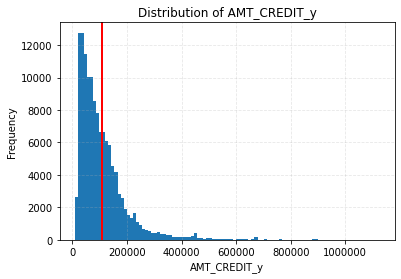

In [ ]:
# 1-1. 히스토그램을 통한 직관적 판단

for i in risk_client_num.columns.tolist():
  plt.hist(risk_client_num[i], bins=100)
  plt.xlabel("{}".format(i))
  plt.ylabel("Frequency")
  plt.title("Distribution of {}".format(i))
  plt.ticklabel_format(style='plain')
  plt.grid(True, alpha = 0.3, linestyle = "--")
  plt.axvline(x = risk_client_num[i].mean(), linewidth = 2, color = 'red')
  plt.show()

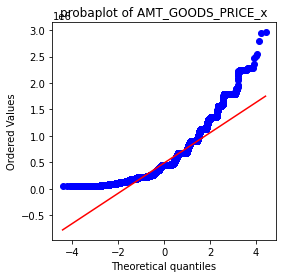

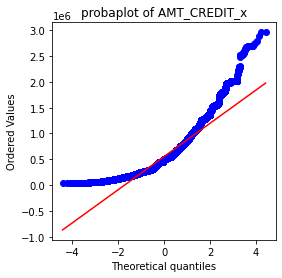

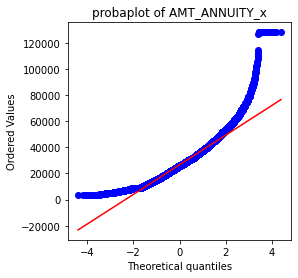

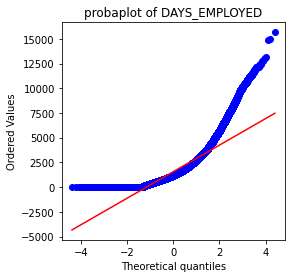

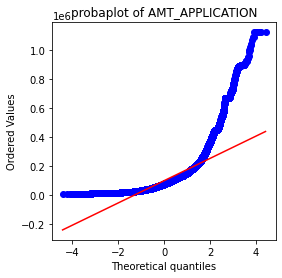

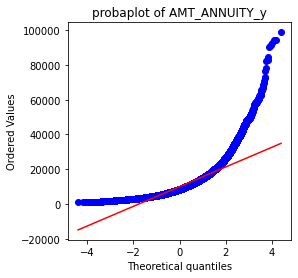

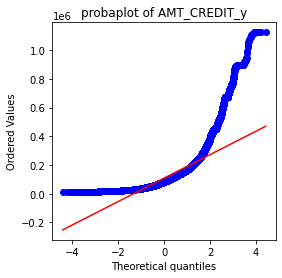

In [ ]:
# QQ-Plot

for i in risk_client_num.columns.tolist():
  fig, ax = plt.subplots(figsize=(4,4))
  stats.probplot(risk_client_num[i], plot = ax)
  ax.set_title("probaplot of {}".format(i))

    # [모든 QQ-Plot이 대각선에 가깝지 않으므로 정규성을 따르지 않음]

In [ ]:
# 1-2. 왜도와 첨도를 통한 기술통계량 판단 : Normal-Test (2-sided 카이제곱 검정 시행)
# H0 : 데이터가 정규 분포를 따른다.
# 검정통계량 = s(왜도)^2 + k(첨도)^2

for i in risk_client_num.columns.tolist():
  nt = stats.normaltest(risk_client_num[i])
  print(i)
  print(nt)

    # [모든 변수가 유의수준 5% 이내에서 H0 기각, 즉 정규성을 만족하지 않는다.]

AMT_GOODS_PRICE_x
NormaltestResult(statistic=33380.68549425739, pvalue=0.0)
AMT_CREDIT_x
NormaltestResult(statistic=28600.231242234375, pvalue=0.0)
AMT_ANNUITY_x
NormaltestResult(statistic=23781.46220065668, pvalue=0.0)
DAYS_EMPLOYED
NormaltestResult(statistic=56127.022201513755, pvalue=0.0)
AMT_APPLICATION
NormaltestResult(statistic=90834.38916512328, pvalue=0.0)
AMT_ANNUITY_y
NormaltestResult(statistic=68833.06226117995, pvalue=0.0)
AMT_CREDIT_y
NormaltestResult(statistic=86631.12122851191, pvalue=0.0)


In [ ]:
# 1-3. 정규성에 대한 가설 검정 : Shapiro test, Anderson test, KS test
# Shapiro-Test

for i in risk_client_num.columns.tolist():
  shapiro_test = stats.shapiro(risk_client_num[i])
  print(i)
  print(shapiro_test)

    # [모든 변수가 유의수준 5% 이내에서 H0 기각, 즉 정규성을 만족하지 않는다.]

AMT_GOODS_PRICE_x
ShapiroResult(statistic=0.8854961395263672, pvalue=0.0)
AMT_CREDIT_x
ShapiroResult(statistic=0.9060527086257935, pvalue=0.0)
AMT_ANNUITY_x
ShapiroResult(statistic=0.9580512642860413, pvalue=0.0)
DAYS_EMPLOYED
ShapiroResult(statistic=0.829912006855011, pvalue=0.0)
AMT_APPLICATION
ShapiroResult(statistic=0.7269043922424316, pvalue=0.0)
AMT_ANNUITY_y
ShapiroResult(statistic=0.8281590342521667, pvalue=0.0)
AMT_CREDIT_y
ShapiroResult(statistic=0.7413502931594849, pvalue=0.0)


/usr/local/lib/python3.8/dist-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
# Anderson-Test

for i in risk_client_num.columns.tolist():
  anderson_result = anderson(risk_client_num[i], dist='norm')
  print(i)
  if anderson_result[0] > anderson_result[1][2]:
    print("귀무가설 기각")
  if anderson_result[0] < anderson_result[1][2]:
    print("귀무가설 채택")

    # [전체 변수 귀무가설 기각]

AMT_GOODS_PRICE_x
귀무가설 기각
AMT_CREDIT_x
귀무가설 기각
AMT_ANNUITY_x
귀무가설 기각
DAYS_EMPLOYED
귀무가설 기각
AMT_APPLICATION
귀무가설 기각
AMT_ANNUITY_y
귀무가설 기각
AMT_CREDIT_y
귀무가설 기각


In [ ]:
# KS-Test

for i in risk_client_num.columns.tolist():
  ks_test = stats.kstest(risk_client_num[i], 'norm')
  print(i)
  print(ks_test)

    # [모든 변수가 유의수준 5% 이내에서 H0 기각, 즉 정규성을 만족하지 않는다.]

AMT_GOODS_PRICE_x
KstestResult(statistic=1.0, pvalue=0.0)
AMT_CREDIT_x
KstestResult(statistic=1.0, pvalue=0.0)
AMT_ANNUITY_x
KstestResult(statistic=1.0, pvalue=0.0)
DAYS_EMPLOYED
KstestResult(statistic=0.9050808716416076, pvalue=0.0)
AMT_APPLICATION
KstestResult(statistic=1.0, pvalue=0.0)
AMT_ANNUITY_y
KstestResult(statistic=1.0, pvalue=0.0)
AMT_CREDIT_y
KstestResult(statistic=1.0, pvalue=0.0)


##### 2) 등분산성 검정

In [ ]:
from scipy.stats import levene

In [ ]:
levene_test = levene(risk_client_num['AMT_CREDIT_y'], risk_client_num['AMT_ANNUITY_y'])
print(levene_test)

LeveneResult(statistic=67697.8422396208, pvalue=0.0)


In [ ]:
# Levene Test : 정규분포를 따르지 않는 데이터 일 때
# H0: σ1 = σ2 = … = σk, 등분산성
for i in risk_client_num.columns.tolist():
  for g in risk_client_num.columns.tolist():
    if i != g:
      levene_test = levene(risk_client_num[i], risk_client_num[g])
      print(i, g)
      print(levene_test)
    else:
      pass

    # [모든 연속형 변수에 대해서 등분산성 조건 성립하지 않음]

AMT_GOODS_PRICE_x AMT_CREDIT_x
LeveneResult(statistic=1455.274820504004, pvalue=1.5268773e-317)
AMT_GOODS_PRICE_x AMT_ANNUITY_x
LeveneResult(statistic=129253.60534592543, pvalue=0.0)
AMT_GOODS_PRICE_x DAYS_EMPLOYED
LeveneResult(statistic=139243.39881992157, pvalue=0.0)
AMT_GOODS_PRICE_x AMT_APPLICATION
LeveneResult(statistic=69727.68680036301, pvalue=0.0)
AMT_GOODS_PRICE_x AMT_ANNUITY_y
LeveneResult(statistic=135091.83276840925, pvalue=0.0)
AMT_GOODS_PRICE_x AMT_CREDIT_y
LeveneResult(statistic=65690.65358045162, pvalue=0.0)
AMT_CREDIT_x AMT_GOODS_PRICE_x
LeveneResult(statistic=1455.274820504004, pvalue=1.5268773e-317)
AMT_CREDIT_x AMT_ANNUITY_x
LeveneResult(statistic=145631.65372269368, pvalue=0.0)
AMT_CREDIT_x DAYS_EMPLOYED
LeveneResult(statistic=155331.61714111592, pvalue=0.0)
AMT_CREDIT_x AMT_APPLICATION
LeveneResult(statistic=86245.79449287549, pvalue=0.0)
AMT_CREDIT_x AMT_ANNUITY_y
LeveneResult(statistic=151306.50788758718, pvalue=0.0)
AMT_CREDIT_x AMT_CREDIT_y
LeveneResult(statis

정규성, 등분산성 검정 결과 두 조건 모두 만족하지 않으므로 비모수적 방법론을 이용해야 한다.

##### 3) 위험 고객의 특징 분석 및 인사이트 추출을 위한 검정

In [ ]:
for i in risk_client_num.columns.tolist():
  plt.hist(risk_client_num[i], bins=100)
  plt.xlabel("{}".format(i))
  plt.ylabel("Frequency")
  plt.title("Distribution of {}".format(i))
  plt.ticklabel_format(style='plain')
  plt.grid(True, alpha = 0.3, linestyle = "--")
  plt.axvline(x = risk_client_num[i].mean(), linewidth = 2, color = 'red')
  plt.show()

NameError: ignored

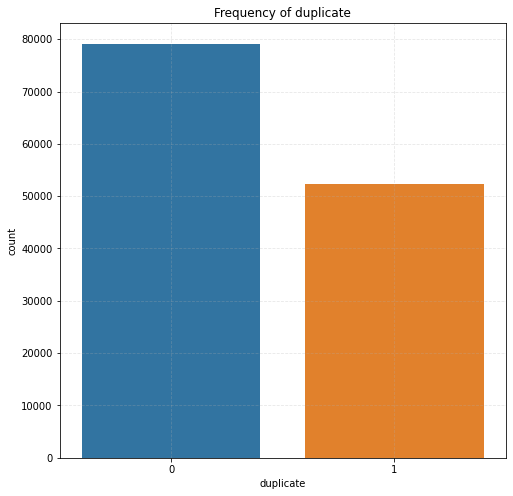

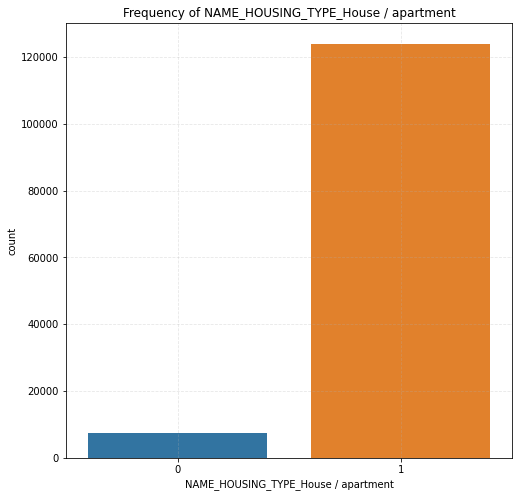

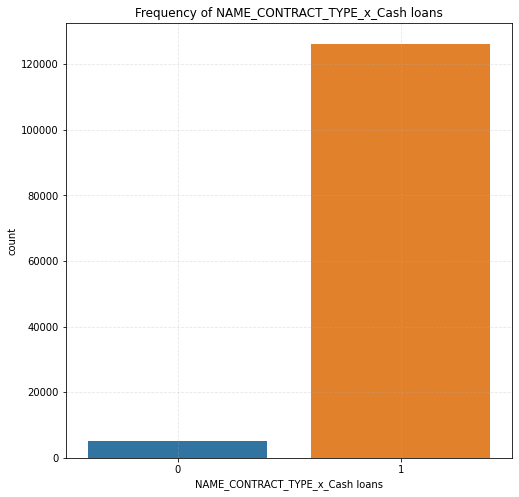

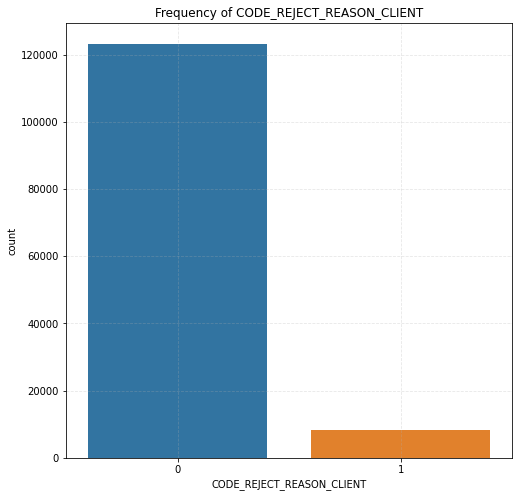

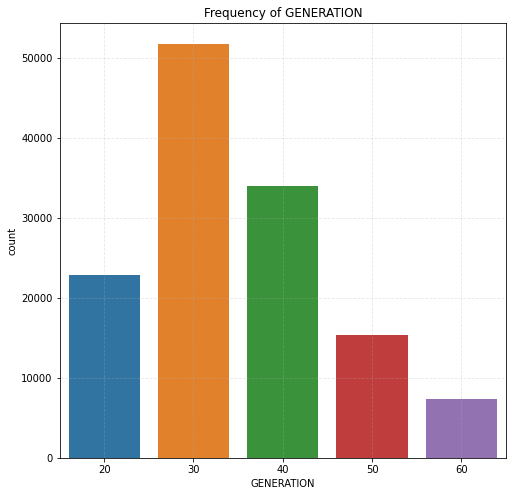

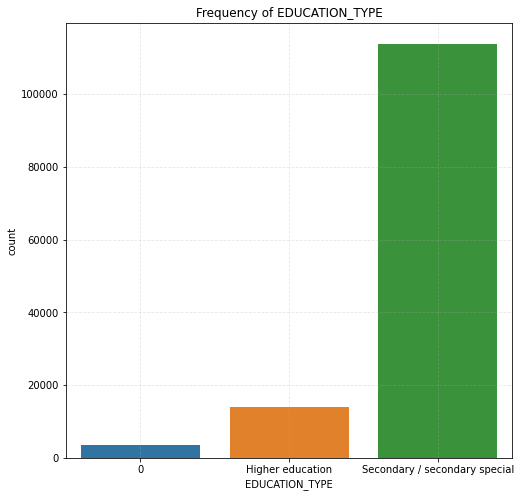

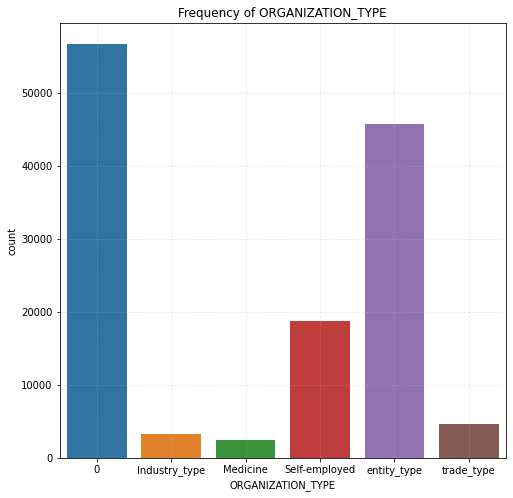

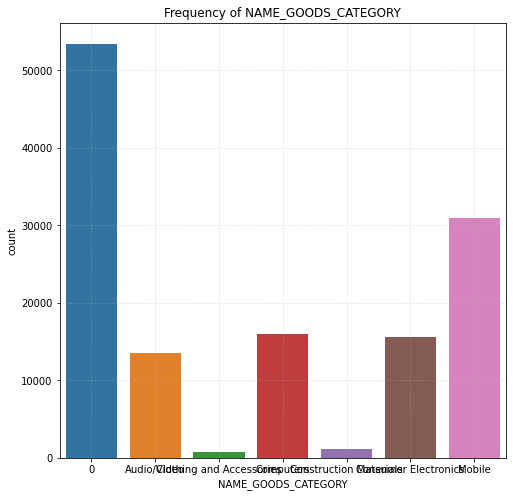

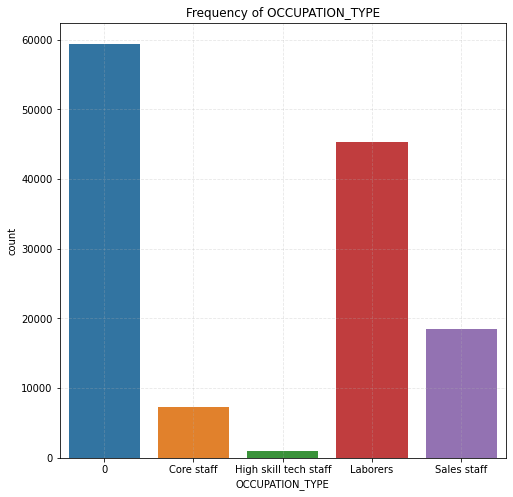

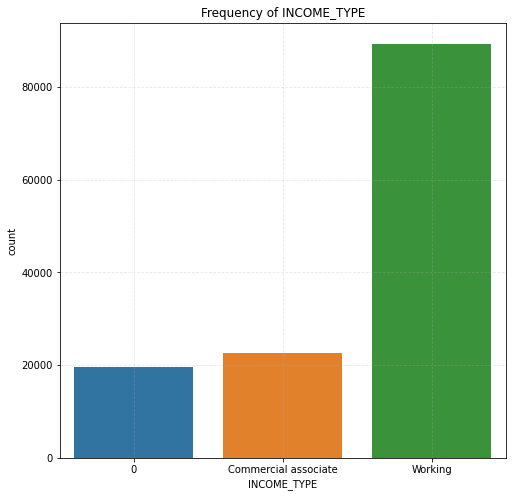

In [ ]:
for i in creditRisk_client.select_dtypes(include="category").columns.tolist():
  fig = plt.figure(figsize = (8,8))
  sns.countplot(data=creditRisk_client, x=i)
  #plt.xlabel("{}".format(i))
  #plt.ylabel("Frequency")
  plt.title("Frequency of {}".format(i))
  plt.grid(True, alpha = 0.3, linestyle = "--")
  plt.show()

In [ ]:
creditRisk_client.head()

,AMT_GOODS_PRICE_x,AMT_CREDIT_x,AMT_ANNUITY_x,DAYS_EMPLOYED,AMT_APPLICATION,AMT_ANNUITY_y,AMT_CREDIT_y,duplicate,NAME_HOUSING_TYPE_House / apartment,NAME_CONTRACT_TYPE_x_Cash loans,CODE_REJECT_REASON_CLIENT,GENERATION,EDUCATION_TYPE,ORGANIZATION_TYPE,NAME_GOODS_CATEGORY,OCCUPATION_TYPE,INCOME_TYPE
0,450000,532361,26987,2383,123594,13173,128545,1,0,1,0,30,Secondary / secondary special,entity_type,0,0,Working
1,264051,312473,17742,1590,25520,5319,26236,0,1,1,0,50,Secondary / secondary special,Self-employed,Mobile,Sales staff,Working
2,314468,314468,30158,1426,29349,3407,30063,0,1,1,0,40,Secondary / secondary special,0,0,Core staff,Working
3,185071,185071,7942,1029,64935,11306,65903,0,1,1,0,30,Secondary / secondary special,Self-employed,Consumer Electronics,Core staff,Working
4,685989,835397,41691,1736,60869,9707,71514,0,1,1,0,40,Secondary / secondary special,entity_type,Consumer Electronics,0,Working


In [ ]:
# LightGBM 모델의 트리 분할에 기여도가 높은(지니 지수 기반의 불순도를 낮추는) 상위 특성변수
# stableCredit_client

stableCredit_client = stableCredit_client.loc[:, featureImportantColumns]
  # [CODE_REJECT_REASON_{}, GENERATION_60.0] 모델의 상위 30개 중요도 높은 특성변수에서 제외되었으나 신용리스크 평가 도메인에 따라 포함

In [ ]:
# 더미변수 타입 변환 (int64 -> category)

stableCredit_client.iloc[:, 7:35] = stableCredit_client.iloc[:, 7:35].astype("category")

'''
# Trial & Error 1
for i in range(len(Capital_creditRisk_client.columns)) :
  if type(Capital_creditRisk_client.iloc[:, i]) == "int64":
    Capital_creditRisk_client.iloc[:, i] = Capital_creditRisk_client.iloc[:, i].astype("category")

# [Trial & Error 2]
Capital_creditRisk_client.select_dtypes(include = "int").columns = Capital_creditRisk_client.select_dtypes(include = "int").columns.astype("category")
'''

'\n# Trial & Error 1\nfor i in range(len(Capital_creditRisk_client.columns)) :\n  if type(Capital_creditRisk_client.iloc[:, i]) == "int64":\n    Capital_creditRisk_client.iloc[:, i] = Capital_creditRisk_client.iloc[:, i].astype("category")\n\n# [Trial & Error 2]\nCapital_creditRisk_client.select_dtypes(include = "int").columns = Capital_creditRisk_client.select_dtypes(include = "int").columns.astype("category")\n'

In [ ]:
transform(stableCredit_client)

Counter({0: 103773, 1: 15741})
Counter({0: 89389, 1: 30125})
Counter({0: 90383, 1: 29131})
Counter({0: 92930, 1: 26584})
Counter({0: 101581, 1: 17933})
Counter({0: 87506, 1: 32008})
Counter({1: 81598, 0: 37916})
32008 81598 5908 0
Counter({0: 91900, 1: 27614})
Counter({0: 114654, 1: 4860})
Counter({0: 113438, 1: 6076})
Counter({0: 113682, 1: 5832})
Counter({0: 106789, 1: 12725})
Counter({0: 101033, 1: 18481})
Counter({0: 103628, 1: 15886})
Counter({0: 114601, 1: 4913})
Counter({0: 104205, 1: 15309})
Counter({0: 101216, 1: 18298})
Counter({0: 114350, 1: 5164})
Counter({0: 91889, 1: 27625})
Counter({0: 111985, 1: 7529})
Counter({0: 104178, 1: 15336})
Counter({0: 103198, 1: 16316})
Counter({0: 92742, 1: 26772})
Counter({0: 60640, 1: 58874})
Counter({'Working': 58874, 0: 33868, 'Commercial associate': 26772})


In [ ]:
stableCredit_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119514 entries, 0 to 119513
Data columns (total 17 columns):
 #   Column                               Non-Null Count   Dtype   
---  ------                               --------------   -----   
 0   AMT_GOODS_PRICE_x                    119514 non-null  int64   
 1   AMT_CREDIT_x                         119514 non-null  int64   
 2   AMT_ANNUITY_x                        119514 non-null  int64   
 3   DAYS_EMPLOYED                        119514 non-null  int64   
 4   AMT_APPLICATION                      119514 non-null  int64   
 5   AMT_ANNUITY_y                        119514 non-null  int64   
 6   AMT_CREDIT_y                         119514 non-null  int64   
 7   duplicate                            119514 non-null  category
 8   NAME_HOUSING_TYPE_House / apartment  119514 non-null  category
 9   NAME_CONTRACT_TYPE_x_Cash loans      119514 non-null  category
 10  CODE_REJECT_REASON_CLIENT            119514 non-null  category
 11  

In [ ]:
stableCredit_client.loc[stableCredit_client["duplicate"] == 1, "AMT_GOODS_PRICE_x"]

0         1125000
1          472500
7          652500
8          117000
9          900000
           ...   
119502     585000
119504     580500
119507     675000
119509      67500
119511    1062000
Name: AMT_GOODS_PRICE_x, Length: 52220, dtype: int64

In [ ]:
# Stable client 와 Risk client의 차이 원인 알아보기
'''
1) duplicate 0>1
2) Housing_TYPE 0<1
3) Name_contract_type_cash loan 0<1
4) code_reject_reason_client 0>1
5) generation 30
6) education_type  secondary
7) organization  entity
8) name_goods_category  mobile
9) occupation  laborers
10) income  working
'''
stableCredit_client_h = stableCredit_client.loc[(stableCredit_client["duplicate"] == 1) & (stableCredit_client["NAME_HOUSING_TYPE_House / apartment"] == 1) &
                                                (stableCredit_client["NAME_CONTRACT_TYPE_x_Cash loans"] == 1) & (stableCredit_client["CODE_REJECT_REASON_CLIENT"] == 0) &
                                                (stableCredit_client["GENERATION"] == 30) & (stableCredit_client["EDUCATION_TYPE"] == "Secondary / secondary special") &
                                                (stableCredit_client["ORGANIZATION_TYPE"] == "entity_type") & (stableCredit_client["NAME_GOODS_CATEGORY"] == "Mobile") &
                                                (stableCredit_client["OCCUPATION_TYPE"] == "Laborers") & (stableCredit_client["INCOME_TYPE"]=="Working"), ["AMT_GOODS_PRICE_x",	"AMT_CREDIT_x",	"AMT_ANNUITY_x",	"DAYS_EMPLOYED",	"AMT_APPLICATION",	"AMT_ANNUITY_y",	"AMT_CREDIT_y"]]

In [ ]:
stableCredit_client_h["TARGET"] = 0

In [ ]:
stableCredit_client_h["TARGET"]

2447      0
3026      0
8809      0
26520     0
26790     0
30160     0
31479     0
41775     0
49084     0
57828     0
68515     0
71743     0
71761     0
72380     0
101300    0
113291    0
114043    0
118230    0
Name: TARGET, dtype: int64

In [ ]:
creditRisk_client_h = creditRisk_client.loc[(creditRisk_client["duplicate"] == 1) & (creditRisk_client["NAME_HOUSING_TYPE_House / apartment"] == 1) &
                                                (creditRisk_client["NAME_CONTRACT_TYPE_x_Cash loans"] == 1) & (creditRisk_client["CODE_REJECT_REASON_CLIENT"] == 0) &
                                                (creditRisk_client["GENERATION"] == 30) & (creditRisk_client["EDUCATION_TYPE"] == "Secondary / secondary special") &
                                                (creditRisk_client["ORGANIZATION_TYPE"] == "entity_type") & (creditRisk_client["NAME_GOODS_CATEGORY"] == "Mobile") &
                                                (creditRisk_client["OCCUPATION_TYPE"] == "Laborers") & (creditRisk_client["INCOME_TYPE"]=="Working"), ["AMT_GOODS_PRICE_x",	"AMT_CREDIT_x",	"AMT_ANNUITY_x",	"DAYS_EMPLOYED",	"AMT_APPLICATION",	"AMT_ANNUITY_y",	"AMT_CREDIT_y"]]

In [ ]:
creditRisk_client_h["TARGET"] = 1

In [ ]:
creditRisk_client_h

,AMT_GOODS_PRICE_x,AMT_CREDIT_x,AMT_ANNUITY_x,DAYS_EMPLOYED,AMT_APPLICATION,AMT_ANNUITY_y,AMT_CREDIT_y,TARGET
657,847849,948575,45273,1894,47252,3930,52625,1
681,180000,215640,13158,5491,24606,2782,24606,1
755,80577,98179,6986,2714,30175,4384,32481,1
963,1057500,1057500,31050,4203,54119,6322,54655,1
1253,490500,542295,42975,844,92871,13404,96183,1
...,...,...,...,...,...,...,...,...
131010,81006,98347,6983,2659,29598,4316,31799,1
131031,900000,900000,31887,1008,23947,4792,26150,1
131061,450000,640080,30955,1358,84729,8553,84729,1
131372,453694,453694,23400,1480,40241,4920,41096,1


In [ ]:
stable_risk_merge = pd.concat([stableCredit_client_h, creditRisk_client_h], axis = 0)

In [ ]:
stable_risk_merge

,AMT_GOODS_PRICE_x,AMT_CREDIT_x,AMT_ANNUITY_x,DAYS_EMPLOYED,AMT_APPLICATION,AMT_ANNUITY_y,AMT_CREDIT_y,TARGET
2447,157500,157500,16268,2803,70600,9268,78057,0
3026,679500,760226,30150,3524,73436,7633,73436,0
8809,1125000,1223010,48501,1788,107622,14468,118989,0
26520,112500,119925,11858,5309,103761,11785,103761,0
26790,225000,343800,10552,5030,14094,3671,14094,0
...,...,...,...,...,...,...,...,...
131010,81006,98347,6983,2659,29598,4316,31799,1
131031,900000,900000,31887,1008,23947,4792,26150,1
131061,450000,640080,30955,1358,84729,8553,84729,1
131372,453694,453694,23400,1480,40241,4920,41096,1


#### In R

    library(readr)
    library(readxl)
    library(dplyr)
    library(rpart)
    library(ggplot2)
    library(MASS)

    stable_risk_merge = read_csv("stable_risk_merge.csv")

    # factor로 변환
    stable_risk_merge$TARGET = ifelse(stable_risk_merge$TARGET == 0, 1, 2)
    stable_risk_merge$TARGET = as.factor(stable_risk_merge$TARGET)
    str(stable_risk_merge)

    list <- cbind(stable_risk_merge$AMT_GOODS_PRICE_x, stable_risk_merge$AMT_CREDIT_x, stable_risk_merge$AMT_ANNUITY_x, stable_risk_merge$DAYS_EMPLOYED, stable_risk_merge$AMT_APPLICATION, stable_risk_merge$AMT_ANNUITY_y, stable_risk_merge$AMT_CREDIT_y)

    # 1. 다변량 일원배치 MANOVA ####
    # http://contents2.kocw.or.kr/KOCW/document/2016/kunsan/jungkangmo/6.pdf
    # 독립변수 : TARGET (범주형), 종속변수 : 연속형 변수
    # 범주형 독립변수에 대한 평균 벡터의 차이를 비교한다.

    summary(manova(list~TARGET, data = stable_risk_merge), test="Wilks")
      # [p-value < 0.05 이므로 H0를 기각한다. 즉, 대출 상환 여부에 따른 연속형 변수의 차이가 있다.]
    summary(manova(list~TARGET, data = stable_risk_merge),test="Pillai")
    summary(manova(list~TARGET, data = stable_risk_merge),test="Hotelling-Lawley")
    summary(manova(list~TARGET, data = stable_risk_merge),test="Roy")


    # 1-1. 사후검정
    # TukeyHSD
    # https://blog.naver.com/jjy0501/221103352978

    TukeyHSD(aov(AMT_CREDIT_x ~ TARGET, data = stable_risk_merge))
        # [0.3152285 > 0.05]
        # [상환할 집단과 하지 않을 집단 간 AMT_CREDIT_x의 차이는 없다.]
    TukeyHSD(aov(AMT_ANNUITY_x ~ TARGET, data = stable_risk_merge))
        # [0.1006358 > 0.05]
        # [상환할 집단과 하지 않을 집단 간 AMT_ANNUITY_x의 차이는 없다.]
    TukeyHSD(aov(DAYS_EMPLOYED ~ TARGET, data = stable_risk_merge))
        # [0.0093725 > 0.05]
        # [상환할 집단과 하지 않을 집단 간 DAYS_EMPLOYED의 차이는 없다.]
    TukeyHSD(aov(AMT_APPLICATION ~ TARGET, data = stable_risk_merge))
        # [0.0005324 < 0.05]
        # [상환할 집단과 하지 않을 집단 간 AMT_APPLICATION의 차이가 있다.]
    TukeyHSD(aov(AMT_ANNUITY_y ~ TARGET, data = stable_risk_merge))
        # [0.0078647 > 0.05]
        # [상환할 집단과 하지 않을 집단 간 AMT_ANNUITY_y의 차이는 없다.]
    TukeyHSD(aov(AMT_CREDIT_y ~ TARGET, data = stable_risk_merge))
        # [0.0005324 < 0.05]
        # [상환할 집단과 하지 않을 집단 간 AMT_CREDIT_y의 차이가 있다.]

    '''
    # [Trial&Error] for문
    colnames <-  names(stable_risk_merge)
    colnames <- colnames[-8]
    colnames

    for(i in colnames){
      print(i)
      #TukeyHSD(aov(i ~ TARGET, data = stable_risk_merge))
    }
    '''

    # TARGET 간 차이를 발생시키는 연속형 변수 : AMT_APPLICATION, AMT_CREDIT_y ####
    # 2. 위 두 변수에 대해 두 변수가 TARGET에 어떻게 영향을 미치는지 이항 로지스틱 회귀분석 진행
    # https://m.blog.naver.com/pmw9440/221894309623

    glm_target <- glm(TARGET ~ AMT_APPLICATION + AMT_CREDIT_y, data = stable_risk_merge, family = binomial)
    summary(glm_target)


    # 연속형 변수에 따라 TARGET에 차이가 있다.
    # H0 : 연속형 변수는 TARGET에 영향을 미치지 않는다.
    glm_all <- glm(TARGET ~ AMT_GOODS_PRICE_x+AMT_CREDIT_x+AMT_ANNUITY_x+DAYS_EMPLOYED+AMT_APPLICATION+AMT_ANNUITY_y+AMT_CREDIT_y,
                  data = stable_risk_merge, family = binomial)
    summary(glm_all)


In [ ]:
# 지금까지 했던 건 다변량 분산분석(종속변수가 여러개인) 이었음 - 의도와 맞지 않음을 확인
# 내가 원하는 건 여러 요인이 TARGET의 변화에 영향을 미치는지 확인하는 것이기 때문에 '일원배치 다원분석'을 해야함.
# https://funnypr.tistory.com/entry/Wilks-Lambda
'''
from statsmodels.multivariate.manova import MANOVA

# Wilks' Lambda : TARGET(독립변수)에 대한 종속변수(AMT_GOODS_PRICE_x ~ AMT_CREDIT_y)의 모평균 벡터가 동일한지 여부를 검정
# H0 : TARGET:1의 모평균 벡터 = TARGET:0의 모평균 벡터

manova_test = MANOVA.from_formula('AMT_GOODS_PRICE_x + AMT_CREDIT_x	+ AMT_ANNUITY_x +	DAYS_EMPLOYED +	AMT_APPLICATION +	AMT_ANNUITY_y +	AMT_CREDIT_y ~ TARGET', stable_risk_merge)
print(manova_test.mv_test())

    # [p-value = 0.0001 < 0.05]
    # [유의수준 0.05에서 귀무가설 기각 ; TARGET에 대한 종속변수의 모평균 벡터에 차이가 있다고 할 수 있다.]

    # [통계량이 다를 때 : 표본크기가 충분하고 가정을 어느정도 충족시키면서 집단의 크기가 유사하면 Wilks' lambda,
    #  표본크기가 작거나 공분산의 동일성 가정을 위해하거나 집단의 크기에 차이가 있으면 Pillasi의 트레이를 적용]
'''

In [ ]:
# stable_risk_merge.to_csv("/content/drive/MyDrive/NewImpact/stable_risk_merge.csv", index = False)

In [ ]:
from statsmodels.formula.api import ols

In [ ]:
# 일원배치 다원 분석

lm_target = lm(TARGET ~ AMT_GOODS_PRICE_x + AMT_CREDIT_x	+ AMT_ANNUITY_x +	DAYS_EMPLOYED +	AMT_APPLICATION +	AMT_ANNUITY_y +	AMT_CREDIT_y, data = stable_ )

In [ ]:
# 사후 검정

##### 4) 중신용자 고객의 특징 분석을 위한 검정과 맞춤 금융 상품 기획